# AnnotationStore Neighbourhood Querying Benchmark

In this notebook the neighbourhood querying capability of the toolbox is benchmarked.

Here we will be searching for annotations labelled "A" within a distance $k$ of annotations labeleld "B":

![nquery Concept Diagram](nquery-concept.svg)

This is done using the `AnnotationStore.nquery` function which is implemented in the abstract base class. This means that all concrete classes (e.g. `DictionaryStore` and `SQLiteStore`) get this functionality. However, it may be overriden in a subclass for improved performance or add implementation specific parameters.

In this benchmark we asses how `nquery()` performs for the task of finding overlapping duplicate geometries. We simply generate a grid of $n \times n$ aritificial cell boundary polygons (random ovals with noise added) labelled with class "A". We then generate another grid of the same side over the top labelled with class "B". We then query with `nquery()` to find all boundaries labelled "A" within a short distance of boundaries labelled "B".

For a naïve implementation this is an $\mathcal{O}(n \times n)$ search and is very slow! Some optimisations in the `SQLiteStore` should allow for this to be performed much more quickly.



# Setup

Here we will import the modules required, print the `nquery()` docstring, and define a function to generate cell boundaries.



In [1]:
"""Import modules required to run the Jupyter notebook."""
from __future__ import annotations

# Clear logger to use tiatoolbox.logger
import logging

if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()

# Import packages needed
import shutil
import sys
from pathlib import Path
from time import perf_counter

import numpy as np
import pandas as pd

# NOTE: This notebook uses maptlotlib 2.3.7+ features
from matplotlib import pyplot as plt
from shapely import affinity
from shapely.geometry import Polygon

sys.path.append("..")  # If running locally without pypi installed tiatoolbox
from tiatoolbox.annotation.storage import (  # noqa: E402
    Annotation,
    AnnotationStore,
    DictionaryStore,
    SQLiteStore,
)

Before we continue, let's print the docstring for `nquery()`:



In [2]:
help(AnnotationStore.nquery)

Help on function nquery in module tiatoolbox.annotation.storage:

nquery(self, geometry: Union[shapely.geometry.point.Point, shapely.geometry.polygon.Polygon, shapely.geometry.linestring.LineString, NoneType] = None, where: Union[str, bytes, Callable[[Dict[str, Union[Dict, List, numbers.Number, str]]], bool], NoneType] = None, n_where: Union[str, bytes, Callable[[Dict[str, Union[Dict, List, numbers.Number, str]]], bool], NoneType] = None, distance: float = 5.0, geometry_predicate: str = 'intersects', mode: str = 'poly-poly') -> Dict[str, Dict[str, tiatoolbox.annotation.storage.Annotation]]
    Query for annotations within a distance of another annotation.
    
    Args:
        geometry (Geometry):
            A geometry to use for the query. If None, the geometry of
            the annotation is used. Defaults to None.
        where (str or bytes or Callable):
            A statement which should evaluate to a boolean value.
            Only annotations for which this predicate is tru

Now we define a function used to generate fake cell boundaries used in the benchmark:



In [3]:
def cell_polygon(
    xy: tuple[float, float],
    n_points: int = 20,
    radius: float = 10,
    noise: float = 0.01,
    eccentricity: tuple[float, float] = (1, 3),
    repeat_first: bool = True,
    direction: str = "CCW",
) -> Polygon:
    """Generate a fake cell boundary polygon.

    Cell boundaries are generated an ellipsoids with randomised eccentricity,
    added noise, and a random rotation.

    Args:
        xy (tuple(int)):
            The x,y centre point to generate the cell boundary around.
        n_points (int):
            Number of points in the boundary. Defaults to 20.
        radius (float):
            Radius of the points from the centre. Defaults to 10.
        noise (float):
            Noise to add to the point locations. Defaults to 1.
        eccentricity (tuple(float)):
            Range of values (low, high) to use for randomised
            eccentricity. Defaults to (1, 3).
        repeat_first (bool):
            Enforce that the last point is equal to the first.
        direction (str):
            Ordering of the points. Defaults to "CCW". Valid options
            are: counter-clockwise "CCW", and clockwise "CW".

    """
    if repeat_first:
        n_points -= 1

    # Generate points about an ellipse with random eccentricity
    x, y = xy
    alpha = np.linspace(0, 2 * np.pi - (2 * np.pi / n_points), n_points)
    rx = radius * (np.random.rand() + 0.5)
    ry = np.random.uniform(*eccentricity) * radius - 0.5 * rx
    x = rx * np.cos(alpha) + x + (np.random.rand(n_points) - 0.5) * noise
    y = ry * np.sin(alpha) + y + (np.random.rand(n_points) - 0.5) * noise
    boundary_coords = np.stack([x, y], axis=1).tolist()

    # Copy first coordinate to the end if required
    if repeat_first:
        boundary_coords = [*boundary_coords, boundary_coords[0]]

    # Swap direction
    if direction.strip().lower() == "cw":
        boundary_coords = boundary_coords[::-1]

    polygon = Polygon(boundary_coords)

    # Add random rotation
    angle = np.random.rand() * 360
    return affinity.rotate(polygon, angle, origin="centroid")

Let's quickly generate and display an example cell boundary to check what they look like:



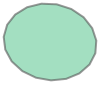

In [4]:
cell_polygon((0, 0))

# Define The Benchmark & A Function To Plot Results

This benchmark can take a very long time to run for high $n$. The results are logged to an CSV as the benchmark runs in case the script is interrupted e.g. by a power cut or shutdown command.

The plot function then reads in the CVS to plot the results.



In [5]:
def main():
    """Run the benchmark."""
    spacing = 30
    radius = 5
    results = {}
    classes = (SQLiteStore, DictionaryStore)
    max_cls_name = max(len(cls.__name__) for cls in classes)
    modes = ("poly-poly", "box-box", "boxpoint-boxpoint")
    max_mode_name = max(len(mode) for mode in modes)

    with Path("nquery-benchmark.csv").open("w") as fh:
        header = "n , time , class , mode"
        print(header)
        fh.write(header + "\n")

        for grid_size in range(10, 60, 10):
            for cls in classes:
                grid = np.ndindex((grid_size, grid_size))
                store: AnnotationStore = cls()

                # Add annotations
                for x, y in grid:
                    cell_a = cell_polygon(
                        xy=(x * spacing + radius, y * spacing + radius),
                        radius=radius,
                    )
                    ann_a = Annotation(cell_a, {"class": "A"})
                    cell_b = cell_polygon(
                        xy=(x * spacing + radius, y * spacing + radius),
                        radius=radius,
                    )
                    ann_b = Annotation(cell_b, {"class": "B"})

                    store[f"A_{x}_{y}"] = ann_a
                    store[f"B_{x}_{y}"] = ann_b

                # Validate annotations were added
                if len(store) != grid_size**2 * 2:
                    msg = "Not all annotations were added."
                    raise ValueError(msg)

                for mode in modes:
                    # Query
                    t0 = perf_counter()
                    result = store.nquery(
                        where="props['class'] == 'A'",
                        n_where="props['class'] == 'B'",
                        distance=2,
                        mode=mode,
                    )
                    t1 = perf_counter()
                    dt = t1 - t0

                    # Validate
                    if not isinstance(result, dict):
                        msg = "Result is not a dictionary."
                        raise TypeError(msg)
                    if len(result) != grid_size**2:
                        msg = "Result does not contain all annotations."
                        raise ValueError(msg)
                    for v in result.values():
                        if len(v) != 1:
                            msg = "Result does not contain the correct number of annotations."
                            raise ValueError(
                                msg,
                            )

                    # Store results
                    results[(grid_size, cls.__name__)] = dt
                    csv_line = " , ".join(
                        [
                            f"{grid_size:>3}",
                            f"{f'{dt:>3.2f}':>8}",
                            f"{cls.__name__: <{max_cls_name}}",
                            f"{mode: <{max_mode_name}}",
                        ],
                    )
                    print(csv_line)
                    fh.write(csv_line + "\n")
                    fh.flush()


def plot_csv() -> tuple[plt.Figure, list[plt.Axes]]:
    """Plot the results from the benchmark."""
    # Use latex for rendering if available
    plt.rc("text", usetex=bool(shutil.which("latex")))
    # Use serif font
    plt.rc("font", family="serif")

    data = pd.read_csv(
        "nquery-benchmark.csv",
        sep=r"\s*,\s*",
        header=0,
        engine="python",
    )
    data = data.pivot(index=["n", "class"], columns="mode", values="time")
    mode_groups = data.groupby("class")
    # Plot each class (group) in a different colour and each mode
    # (series) in a different line style.
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), layout="constrained")
    for n, (cls, group) in enumerate(mode_groups):
        for m, (mode, series) in enumerate(group.items()):
            for a, ax in enumerate(axs):
                ax.plot(
                    range(len(series.index)),
                    series,
                    label=f"{cls}\n({mode})" if a == 0 else None,
                    c=f"C{n}",
                    linestyle=["--", ":", "-"][m],
                )
                ax.grid("on")
                ax.set_xlabel("$n$")
                ax.set_ylabel("Time (s)")
                ax.set_xticks(
                    range(len(group.index)),
                    labels=group.index.get_level_values("n"),
                )
    fig.legend(loc="outside right")
    axs[1].set_yscale("log")
    axs[0].set_title("Linear Scale")
    axs[1].set_title("Log Scale")
    plt.suptitle(
        "Neighbourhood Query Performance For Two Overlaid"
        " $n \\times n$ Grids of Polygons",
    )
    return fig, axs

# Run The Benchmark



In [5]:
main()

n , time , class , mode
 10 ,     0.04 , SQLiteStore     , poly-poly        
 10 ,     0.02 , SQLiteStore     , box-box          
 10 ,     0.03 , SQLiteStore     , boxpoint-boxpoint
 10 ,     0.05 , DictionaryStore , poly-poly        
 10 ,     1.55 , DictionaryStore , box-box          
 10 ,     1.04 , DictionaryStore , boxpoint-boxpoint
 20 ,     0.15 , SQLiteStore     , poly-poly        
 20 ,     0.08 , SQLiteStore     , box-box          
 20 ,     0.14 , SQLiteStore     , boxpoint-boxpoint
 20 ,     0.62 , DictionaryStore , poly-poly        
 20 ,    24.59 , DictionaryStore , box-box          
 20 ,    16.28 , DictionaryStore , boxpoint-boxpoint
 30 ,     0.33 , SQLiteStore     , poly-poly        
 30 ,     0.19 , SQLiteStore     , box-box          
 30 ,     0.42 , SQLiteStore     , boxpoint-boxpoint
 30 ,     2.96 , DictionaryStore , poly-poly        
 30 ,   124.78 , DictionaryStore , box-box          
 30 ,    82.49 , DictionaryStore , boxpoint-boxpoint
 40 ,     0.59 , SQLit

# Plot Results



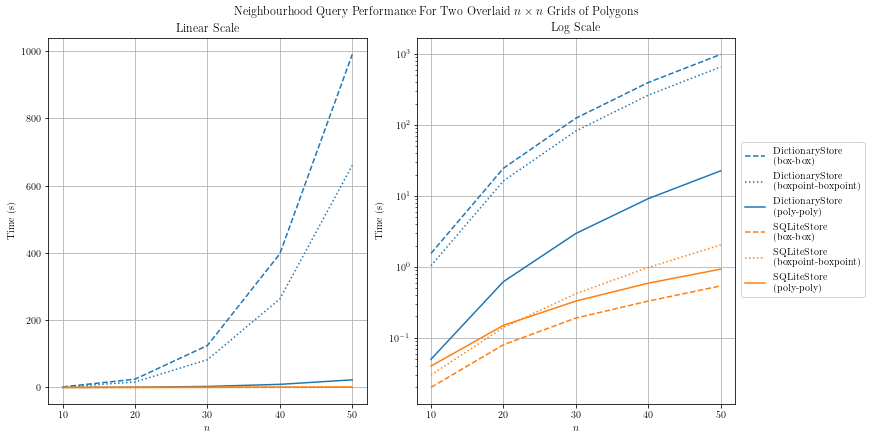

In [6]:
plot_csv()
plt.show()